# Imports

In [1]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd
import numpy as np

In [3]:
import nfl_data_py as nfl

# Grabbing Data

In [4]:
seasons = range(2012, 2022 + 1)
df_pbp = nfl.import_pbp_data(seasons) 

2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


In [5]:
df_seasonal = nfl.import_seasonal_data(seasons)

In [6]:
df_roster = nfl.import_seasonal_rosters(seasons)

In [7]:
df_ngs = nfl.import_ngs_data(stat_type="passing", years=seasons)

## Saving dfs to pkl

In [19]:
file_path = "../../interactive/QB"

In [20]:
df_pbp.to_pickle(f"{file_path}/df_pbp_2012_2022.pkl")

In [21]:
df_seasonal.to_pickle(f"{file_path}/df_seasonal_2012_2022.pkl")

In [22]:
df_roster.to_pickle(f"{file_path}/df_roster_2012_2022.pkl")

In [23]:
df_ngs.to_pickle(f"{file_path}/df_ngs_2012_2022.pkl")

# Grabbing Only Pass Data

Cleaning and creating our dedicated passing dataframe:

In [24]:
df_passes = df_pbp.query("play_type == 'pass' & air_yards.notnull() & season_type == 'REG'").reset_index()

In [25]:
df_passes.head()

,index,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,...,offense_formation,offense_personnel,defenders_in_box,defense_personnel,number_of_pass_rushers,players_on_play,offense_players,defense_players,n_offense,n_defense
0,4,95.0,2012_01_ATL_KC,2012090908,KC,ATL,REG,1,ATL,away,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,119.0,2012_01_ATL_KC,2012090908,KC,ATL,REG,1,ATL,away,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6,143.0,2012_01_ATL_KC,2012090908,KC,ATL,REG,1,ATL,away,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8,186.0,2012_01_ATL_KC,2012090908,KC,ATL,REG,1,ATL,away,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,210.0,2012_01_ATL_KC,2012090908,KC,ATL,REG,1,ATL,away,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Distinguishing between long and short passes.

In [26]:
df_passes["pass_length_air_yards"] = np.where(
      df_passes["air_yards"] >= 20, "long", "short"
)

Setting null yardage values to 0

In [27]:
df_passes["passing_yards"] = np.where(
          df_passes["passing_yards"].isnull(), 0,
          df_passes["passing_yards"]
        )

Accumulating the play by play stats into season stats

In [28]:
df_passing_yards_by_season = df_passes \
    .groupby(["passer_id", "passer", "season"]) \
    .agg({"passing_yards": ["sum", "count", "mean"], "epa": ["sum"],
          "pass_touchdown": ["sum"], "complete_pass": ["sum"]}
    )

In [29]:
df_passing_yards_by_season.head()

passing_yards                         epa  \
                                         sum count       mean        sum   
passer_id  passer       season                                             
00-0000865 C.Batch      2012           475.0    70   6.785714  -4.666173   
00-0007091 M.Hasselbeck 2012          1367.0   221   6.185520  -3.358989   
                        2013           130.0    12  10.833333   3.809972   
                        2014           301.0    44   6.840909   6.072737   
                        2015          1690.0   256   6.601562  31.047590   

                               pass_touchdown complete_pass  
                                          sum           sum  
passer_id  passer       season                               
00-0000865 C.Batch      2012              1.0          45.0  
00-0007091 M.Hasselbeck 2012              7.0         138.0  
                        2013              0.0           7.0  
                        2014              2.0          30.0  
                        2015              9.0         156.0

In [30]:
df_passing_yards_by_season.columns = list(map("_".join, df_passing_yards_by_season.columns))
df_passing_yards_by_season.reset_index(inplace=True)

In [31]:
new_cols = ["passer_id", "passer", "season", "passing_yards", "passing_attempts", "yards_per_pass", "total_epa",
            "passing_touchdowns", "completions"]
df_passing_yards_by_season.columns = new_cols

In [32]:
df_passing_yards_by_season.head()

,passer_id,passer,season,passing_yards,passing_attempts,yards_per_pass,total_epa,passing_touchdowns,completions
0,00-0000865,C.Batch,2012,475.0,70,6.785714,-4.666173,1.0,45.0
1,00-0007091,M.Hasselbeck,2012,1367.0,221,6.185520,-3.358989,7.0,138.0
2,00-0007091,M.Hasselbeck,2013,130.0,12,10.833333,3.809972,0.0,7.0
3,00-0007091,M.Hasselbeck,2014,301.0,44,6.840909,6.072737,2.0,30.0
4,00-0007091,M.Hasselbeck,2015,1690.0,256,6.601562,31.047590,9.0,156.0


In [33]:
for i, row in df_passing_yards_by_season.iterrows():
    r_id = row["passer_id"]
    season = row["season"]
    
    seasonal_row = df_seasonal.query(f"player_id == '{r_id}' & season == {season} & season_type == 'REG'")
    age = df_roster.query(f"player_id == '{r_id}' & season == {season}")["age"]
    
    # from seasonal df
    df_passing_yards_by_season.at[i, "games"] = seasonal_row["games"].iloc[0]
    df_passing_yards_by_season.at[i, "fantasy_points"] = seasonal_row["fantasy_points"].iloc[0]
    
    
    # from roster df
    df_passing_yards_by_season.at[i, "age"] = age.iloc[0]

In [34]:
# df_passing_yards_by_season = df_passing_yards_by_season.query("games >= 12 & passing_yards > 1000")

In [35]:
df_passing_yards_by_season.head()

,passer_id,passer,season,passing_yards,passing_attempts,yards_per_pass,total_epa,passing_touchdowns,completions,games,fantasy_points,age
0,00-0000865,C.Batch,2012,475.0,70,6.785714,-4.666173,1.0,45.0,2.0,15.00,37.0
1,00-0007091,M.Hasselbeck,2012,1367.0,221,6.185520,-3.358989,7.0,138.0,8.0,76.48,36.0
2,00-0007091,M.Hasselbeck,2013,130.0,12,10.833333,3.809972,0.0,7.0,3.0,3.00,37.0
3,00-0007091,M.Hasselbeck,2014,301.0,44,6.840909,6.072737,2.0,30.0,4.0,16.94,38.0
4,00-0007091,M.Hasselbeck,2015,1690.0,256,6.601562,31.047590,9.0,156.0,8.0,91.10,39.0


Creating a current and last year df to compare stats year over year:

In [36]:
df_now = df_passing_yards_by_season.copy()
df_last = df_passing_yards_by_season.copy()

In [37]:
df_last.rename(columns= {
        'passing_yards': 'passing_yards_last',
        'passing_attempts': 'passing_attempts_last',
        'yards_per_pass': 'yards_per_pass_last',
        'total_epa': 'total_epa_last',
        'passing_touchdowns': 'passing_touchdowns_last',
        'completions': 'completions_last',
        'games': 'games_last',
        'age': 'age_last',
        'fantasy_points': 'fantasy_points_last'
    }, inplace=True)

In [38]:
df_last["season"] += 1

Merging the two for comparison purposes:

In [39]:
df_lag = df_now.merge(df_last, how='inner', on=['passer_id', 'passer', 'season'])

In [40]:
df_lag.head()

,passer_id,passer,season,passing_yards,passing_attempts,yards_per_pass,total_epa,passing_touchdowns,completions,games,...,age,passing_yards_last,passing_attempts_last,yards_per_pass_last,total_epa_last,passing_touchdowns_last,completions_last,games_last,fantasy_points_last,age_last
0,00-0007091,M.Hasselbeck,2013,130.0,12,10.833333,3.809972,0.0,7.0,3.0,...,37.0,1367.0,221,6.185520,-3.358989,7.0,138.0,8.0,76.48,36.0
1,00-0007091,M.Hasselbeck,2014,301.0,44,6.840909,6.072737,2.0,30.0,4.0,...,38.0,130.0,12,10.833333,3.809972,0.0,7.0,3.0,3.00,37.0
2,00-0007091,M.Hasselbeck,2015,1690.0,256,6.601562,31.047590,9.0,156.0,8.0,...,39.0,301.0,44,6.840909,6.072737,2.0,30.0,4.0,16.94,38.0
3,00-0010346,P.Manning,2013,5477.0,658,8.323709,289.987091,55.0,450.0,16.0,...,37.0,4659.0,580,8.032759,189.008911,37.0,400.0,16.0,310.96,36.0
4,00-0010346,P.Manning,2014,4727.0,595,7.944538,147.676483,39.0,395.0,16.0,...,38.0,5477.0,658,8.323709,289.987091,55.0,450.0,16.0,409.98,37.0


In [41]:
df_lag.to_pickle("../../interactive/QB/stability-passing/df_lag_unfiltered.pkl")

In [ ]:
df_lag_150 = df_lag.query("completions > 150").copy()
df_lag_150["diff"] = df_lag_150["passing_yards"] - df_lag_150["passing_yards_last"]
df_lag_150.head()

In [ ]:
df_lag_300 = df_lag.query("completions > 300")
df_lag_300.head()

# Correlations

## Completions

In [ ]:
df_lag[["completions", "completions_last"]].corr()

## Attempts

In [ ]:
df_lag[["passing_attempts", "passing_attempts_last"]].corr()

## Yardage

In [ ]:
df_lag[["passing_yards", "passing_yards_last"]].corr()

## Touchdowns

In [ ]:
df_lag[["passing_touchdowns", "passing_touchdowns_last"]].corr()

## EPA

In [ ]:
df_lag[["total_epa", "total_epa_last"]].corr()

# Further Exploration

In [ ]:
df_lag["completions"].mean()

In [ ]:
df_lag["completions"].median()

In [ ]:
for thres in range(200, 460, 10):
    df_lag_test = df_lag.query(f"completions > {thres}")
    temp = df_lag_test[["completions", "completions_last"]].corr()
    
    print(f"\nMin completions for season: {thres}")
    print(temp.to_string())

In [ ]:
for thres in range(2000, 5500, 100):
    df_lag_test = df_lag
    df_lag_test["passing_yards"] = df_lag_test["passing_yards"]
    df_lag_test = df_lag_test.query(f"passing_yards > {thres}")
    temp = df_lag_test[["passing_yards", "passing_yards_last"]].corr()
    
    print(f"\nMin yards for season: {thres}")
    print(temp.to_string())

## Plotting Merged Data

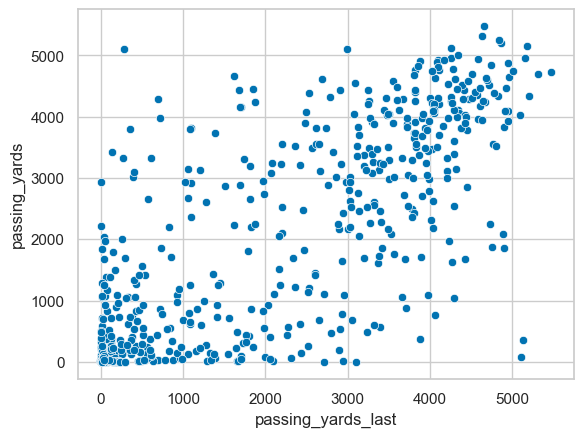

In [33]:
sns.set_theme(style="whitegrid", palette="colorblind")
sns.scatterplot(data=df_lag, x="passing_yards_last", y="passing_yards");
plt.show();

In [ ]:
sns.regplot(data=df_lag, x="passing_yards_last", y="passing_yards");
plt.show();

In [ ]:
df_lag_ols = smf.ols(formula='passing_yards ~ 1 + passing_yards_last', data=df_lag)
print(df_lag_ols.fit().summary())

## Looking at Small Changes

In [ ]:
df_small_change = df_lag_150[["passer", "season", "passing_yards", 
                  "passing_yards_last", "diff", "completions"]
                ].query("diff < 1000 & diff > -1000")

In [ ]:
df_small_change[["passing_yards", "passing_yards_last"]].corr()

## Looking at Large Changes

In [ ]:
df_big_pos_del = df_lag_150[["passer", "season", "passing_yards", 
                  "passing_yards_last", "diff", "completions"]
                ].query("diff > 1000")
df_big_pos_del 

In [ ]:
df_big_minus_del = df_lag_150[["passer", "season", "passing_yards", 
                  "passing_yards_last", "diff", "completions"]
                ].query("diff < -1000")
df_big_minus_del

## Looking at healthy starters over two seasons

In [ ]:
df_starter = df_lag_150[["passer", "season", "passing_yards", 
                  "passing_yards_last", "diff", "completions", "games", "games_last"]
                ].query("games > 12 & games_last > 12")
df_starter

In [ ]:
df_starter[["passing_yards", "passing_yards_last"]].corr()

In [ ]:
sns.set_theme(style="whitegrid", palette="colorblind")
sns.scatterplot(data=df_starter, x="passing_yards_last", y="passing_yards");
plt.show();

In [ ]:
sns.regplot(data=df_starter, x="passing_yards_last", y="passing_yards");
plt.show();

In [ ]:
df_lag_ols = smf.ols(formula='passing_yards ~ 1 + passing_yards_last', data=df_starter)
print(df_lag_ols.fit().summary())

## Starters with more than 2000 passing yards

In [ ]:
df_starter_2000 = df_lag_150[["passer", "season", "passing_yards", 
                  "passing_yards_last", "diff", "completions", "games", "games_last"]
                ].query("games > 12 & games_last > 12 & passing_yards_last > 2000")
df_starter_2000

In [ ]:
sns.set_theme(style="whitegrid", palette="colorblind")
sns.scatterplot(data=df_starter_2000, x="passing_yards_last", y="passing_yards");
plt.show();

In [ ]:
sns.regplot(data=df_starter_2000, x="passing_yards_last", y="passing_yards");
plt.show();

In [ ]:
df_lag_ols = smf.ols(formula='passing_yards ~ 1 + passing_yards_last', data=df_starter_2000)
print(df_lag_ols.fit().summary())

## Negative Delta

In [ ]:
df_neg = df_lag_150[["passer", "season", "passing_yards", 
                  "passing_yards_last", "diff", "completions", 'age', 'age_last']
                ].query("diff < -400")
df_neg.head()

In [ ]:
df_neg["age"].mean()

In [ ]:
df_neg["age"].median()

## Postive Delta

In [ ]:
df_pos = df_lag_150[["passer", "season", "passing_yards", 
                  "passing_yards_last", "diff", "completions", 'age', 'age_last']
                ].query("diff > 400")
df_pos.head()

In [ ]:
df_pos["age"].mean()

In [ ]:
df_pos["age"].median()

# Olds QBs

In [ ]:
df_old = df_lag.query('age_last >= 30')

In [ ]:
sns.set_theme(style="whitegrid", palette="colorblind")
sns.scatterplot(data=df_old, x="passing_yards_last", y="passing_yards");
plt.show();

In [ ]:
sns.regplot(data=df_old, x="passing_yards_last", y="passing_yards");
plt.show();

In [ ]:
df_lag_ols = smf.ols(formula='passing_yards ~ 1 + passing_yards_last', data=df_lag)
print(df_lag_ols.fit().summary())

In [ ]:
df_old[["passing_yards", "passing_yards_last"]].corr()

# Young QBs

In [ ]:
df_young = df_lag.query('age <= 30')

In [ ]:
sns.set_theme(style="whitegrid", palette="colorblind")
sns.scatterplot(data=df_young, x="passing_yards_last", y="passing_yards");
plt.show();

In [ ]:
sns.regplot(data=df_young, x="passing_yards_last", y="passing_yards");
plt.show();

In [ ]:
df_lag_ols = smf.ols(formula='passing_yards ~ 1 + passing_yards_last', data=df_young)
print(df_lag_ols.fit().summary())

In [ ]:
df_young[["passing_yards", "passing_yards_last"]].corr()

## Looking at the Diff Year-to-Year

In [ ]:
df_lag_150["diff"].mean()

In [ ]:
df_lag_150["diff"].median()

In [ ]:
df_lag_150["diff"].describe()

### Top 25 Percentile

In [ ]:
df_top_25 = df_lag_150.query("diff > 509.25")
df_top_25[["passer", "season", "age", "diff"]].head()

In [ ]:
df_top_25["age"].mean()

In [ ]:
df_top_25["age"].median()

In [ ]:
df_top_25[["passing_yards", "passing_yards_last"]].corr()

In [ ]:
sns.set_theme(style="whitegrid", palette="colorblind")
sns.scatterplot(data=df_top_25, x="passing_yards_last", y="passing_yards");
plt.show();

In [ ]:
sns.regplot(data=df_top_25, x="passing_yards_last", y="passing_yards");
plt.show();

In [ ]:
df_lag_ols = smf.ols(formula='passing_yards ~ 1 + passing_yards_last', data=df_top_25)
print(df_lag_ols.fit().summary())

### Bottom 25 Percentile

In [ ]:
df_bot_25 = df_lag_150.query("diff < -438.5")
df_bot_25[["passer", "season", "age", "diff"]].head()

In [ ]:
df_bot_25["age"].mean()

In [ ]:
df_bot_25["age"].median()

In [ ]:
df_bot_25[["passing_yards", "passing_yards_last"]].corr()

In [ ]:
sns.set_theme(style="whitegrid", palette="colorblind")
sns.scatterplot(data=df_bot_25, x="passing_yards_last", y="passing_yards");
plt.show();

In [ ]:
sns.regplot(data=df_bot_25, x="passing_yards_last", y="passing_yards");
plt.show();

In [ ]:
df_lag_ols = smf.ols(formula='passing_yards ~ 1 + passing_yards_last', data=df_bot_25)
print(df_lag_ols.fit().summary())